In [14]:
# noise_type = {'Gaussian', 'Correlated', 'Mixture'}
noise_type = 'Correlated'
noise_value = 25

if noise_type == 'Gaussian':
    data_type = noise_type + '_std' + str(noise_value)
elif noise_type == 'Correlated':
    data_type = noise_type + '_std' + str(noise_value)
elif noise_type == 'Mixture':
    data_type = noise_type + '_s' + str(noise_value)
    
    if noise_value == 15 or noise_value == 25:
        gaussian_std1 = 1
        gaussian_std2 = 0.1
    elif noise_value == 30 or noise_value == 50:
        gaussian_std1 = 25
        gaussian_std2 = 15
    else:
        print ('unexpected noise value : ', noise_value)
        

In [15]:
folder_dir = './BSD68/'

In [16]:
import os
import h5py
import numpy as np

def search(dirname):
    filenames = os.listdir(dirname)
    return filenames

In [17]:
gt_filename = search(folder_dir)
print (len(gt_filename))

68


In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [19]:
import random
from scipy import signal
import math

def correlated_gaussian_noise(patch, mean=0, std=25, r=0.7, k=16):
    
    size_x = patch.shape[0]
    size_y = patch.shape[1]
    
    noise = np.random.normal(0,std,(size_x,size_y))
    
    nb = np.ones((k,k))
    nb[k//2, k//2] = 0
    
    correlated_noise = noise.copy()
    conv = signal.convolve2d(correlated_noise, nb, mode='same', boundary = 'fill', fillvalue = 0)
    
    correlated_noise = patch + correlated_noise * r + (1-r) * conv/(math.sqrt(k*k-1))
    return correlated_noise

In [20]:
def generate_mixture_noise(patch, s=15, gaussian_std1 = 0.1, gaussian_std2 = 1, uniform_p=0.1, gaussian1_p=0.2, gaussian2_p=0.7):
    
    size_x = patch.shape[0]
    size_y = patch.shape[1]
    
    rand = np.random.rand(size_x,size_y)
    uniform = np.random.uniform(-s,s,size=(size_x,size_y))
    gaussian1 = np.random.normal(0,gaussian_std1,size=(size_x,size_y))
    gaussian2 = np.random.normal(0,gaussian_std2,size=(size_x,size_y))
    
    uniform_flag = np.where(rand < uniform_p, 1, 0)
    gaussian1_flag = np.where(rand >= uniform_p,  (np.where(rand < uniform_p + gaussian1_p, 1, 0)), 0)
    gaussian2_flag = np.where(rand >= uniform_p + gaussian1_p,1,0)

    mixture_noisy_img = patch + uniform*uniform_flag + gaussian1*gaussian1_flag + gaussian2*gaussian2_flag

    return mixture_noisy_img

In [21]:
from scipy.ndimage import imread

gt_arr = []

for file_name in (gt_filename):
    img_full_name = folder_dir + '/' + file_name
    img = imread(img_full_name)
    gray_img = rgb2gray(img)
    if gray_img.shape[0] > gray_img.shape[1]:
        gray_img = gray_img.transpose()
    gt_arr.append(gray_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys


In [22]:
clean = np.array(gt_arr, dtype = np.float32)
print (clean.shape)

(68, 321, 481)


In [23]:
noisy_arr = []

for file_name in (gt_filename):
    img_full_name = folder_dir + '/' + file_name
    img = imread(img_full_name)
    gray_img = rgb2gray(img)
    
    if noise_type == 'Gaussian':
        noisy_img = gray_img + np.random.normal(0, noise_value, gray_img.shape)
    elif noise_type == 'Correlated':
        noisy_img = correlated_gaussian_noise(gray_img, 0, noise_value)
    elif noise_type == 'Mixture':
        noisy_img = generate_mixture_noise(gray_img, noise_value, gaussian_std1, gaussian_std2)
        
    if noisy_img.shape[0] > noisy_img.shape[1]:
        noisy_img = noisy_img.transpose()
    noisy_arr.append(noisy_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """


In [24]:
noisy = np.array(noisy_arr, dtype = np.float32)
print (noisy.shape)

(68, 321, 481)


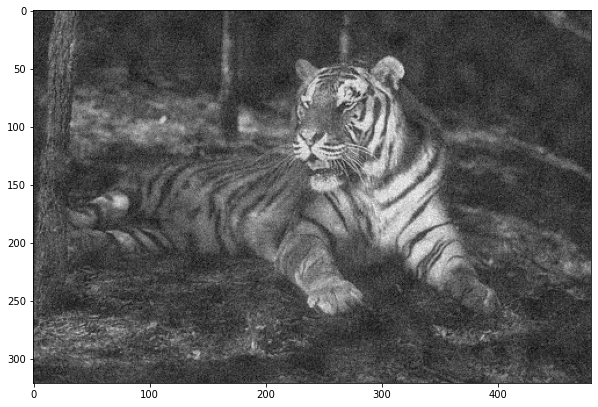

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,8])
plt.imshow(noisy[-1], cmap='gray')
plt.show()

In [26]:
import h5py
file_name = 'BSD_'+data_type+'_test.hdf5'
f = h5py.File(file_name, "w")
f.create_dataset('clean_images', data=np.array(clean, dtype=np.float32)/255.)
f.create_dataset('noisy_images', data=np.array(noisy, dtype=np.float32)/255.)
f.close()